# Training a DCGAN I
## (Deep Convolutional Generative Adversarial Networks)

This is adapted from [this TF tutorial](https://www.tensorflow.org/tutorials/generative/dcgan), (you can also look at [this Chollet notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter12_part05_gans.ipynb), itself a port of [this Keras tutorial](https://keras.io/examples/generative/dcgan_overriding_train_step/).

#### Install Imageio (to generate GIFs at the end)

```bash
conda install -c conda-forge imageio # locally (ships with Colab)
```

In [1]:
import os
import sys
import PIL
import time
import glob
import imageio
import pathlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.config.experimental.set_visible_devices([], 'GPU')

from IPython import display

In [2]:
# reminder: Colab code to mount your drive
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/')  # 'My Drive' is the default name of Google Drives
    os.chdir('drive/My Drive/2023-DMLAP/DMLAP') # change to your favourite dir

## Prepare our Dataset

### Train on [MNIST](https://www.tensorflow.org/datasets/catalog/mnist)

Note: the code below also works with [Fashion MNIST](https://paperswithcode.com/dataset/fashion-mnist)!, and it's an easy, drop-in replacement:
```python
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
```

One cool project could be to create a synthetic/generative dataset like those two (60k b&w 28x28 pixel images)!

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
# utils 

def norm(x):
    """Normalize the inputs to [-1, 1] (generator with 'tanh' activation)"""
    return (x - 127.5) / 127.5

def denorm(x):
    """Denormalize the outputs from [-1, 1] to [0,255] (generator with 'tanh' activation)"""
    return (x + 1) * 127.5

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = norm(train_images)  # Normalize the images to [-1, 1]

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
IMAGE_SHAPE = train_images[0].shape # height, width, channels
IMAGE_CHANNELS = IMAGE_SHAPE[-1]

LATENT_DIM = 100 # The size of the latent space/input vector

Using the [built-in TF data pipeline](https://www.tensorflow.org/guide/data).

In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-10-16 21:59:49.686099: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


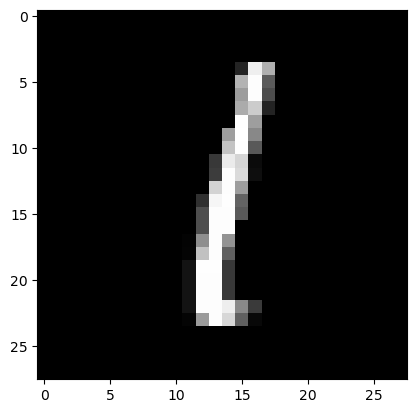

In [8]:
for x in train_dataset:
    a = denorm(x[0])
    # print(tf.reduce_min(a), tf.reduce_max(a))
    plt.imshow(tf.cast(a, tf.int32), cmap='gray')
    break

In [9]:
ds_len = len(train_dataset)
print(f"{ds_len * BATCH_SIZE} samples in {ds_len} batches")

60160 samples in 235 batches


## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(IMAGE_CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                              activation='tanh')) # tanh: output will be between [-1, 1]
    assert model.output_shape == (None, *IMAGE_SHAPE)

    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

Let&rsquo;s see it&rsquo;s output before training



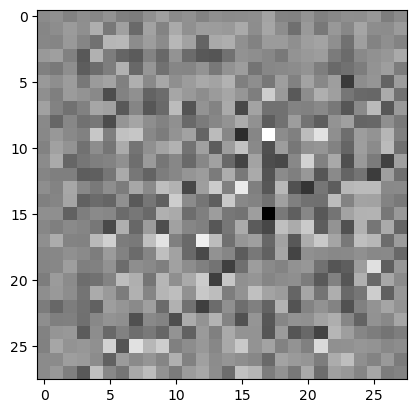

In [11]:
noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0], cmap='gray')

### The Discriminator

The discriminator is a CNN-based image classifier.

In [12]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=IMAGE_SHAPE))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [13]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.50073534]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [14]:
# This method returns a helper function to compute cross entropy loss
loss_function = tf.keras.losses.BinaryCrossentropy()

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [16]:
def generator_loss(fake_output):
    return loss_function(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [18]:
# on TF metal you might want to switch to tf.keras.optimizers.legacy.Adam
generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [22]:
model_dir = '/Users/jcw/Desktop/dcgan_mnist.mac'
 
if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

generated_dir = '/Users/jcw/Desktop/dcgan_mnist.mac/images'

if not os.path.isdir(generated_dir):
    os.makedirs(generated_dir)

## Define the training loop


In [23]:
EPOCHS = 100

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, LATENT_DIM])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [25]:
# limit the dataset if you need to speed things up
max_batches = 100 # -1 to disable

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        tot = len(dataset)
        msg = ""
        for i, image_batch in enumerate(dataset):
            
            if i == max_batches:
                break
                
            gen_loss, disc_loss = train_step(image_batch)
            if i % 10 == 0:
                print(" " * len(msg), end="\r") # erase the previous line
                gl, dl = gen_loss.numpy().item(), disc_loss.numpy().item()
                print(f"epoch {epoch} | batch: {i:{len(str(tot))}}/{tot} |generator loss {gl:.5f} | discriminator loss: {dl:.5f}", end="\r") # print and carriage return
        
        print()

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(
            generator, epoch + 1, seed, cmap="gray" if IMAGE_CHANNELS == 1 else None
        )

        # Save the generator every 15 epochs
        if (epoch + 1) % 15 == 0:
            generator.save(os.path.join(model_dir, f"e{EPOCHS}_generator_mnist.keras"))

        print (f"time for epoch {epoch + 1} is {time.time()-start} sec")

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(
        generator, epochs, seed, cmap="gray" if IMAGE_CHANNELS == 1 else None
    )

**Generate and save images**


In [26]:
def generate_and_save_images(model, epoch, latent_vectors, cmap="gray"):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(latent_vectors, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(denorm(predictions[i, :, :, 0]), cmap=cmap)
        plt.axis('off')
    # IDEA: save individual images instead of the grid, or change this function
    # to allow for different grid sizes (not just 16 images as 4x4)
    plt.savefig(os.path.join(generated_dir, f"image_at_epoch_{epoch:04d}.png"))
    plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [ ]:
train(train_dataset, EPOCHS)

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open(
        os.path.join(generated_dir, f'image_at_epoch_{epoch_no:04d}.png')
    ).convert('RGB')

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
import imageio as iio
import glob

anim_file = os.path.join(model_dir, 'dcgan_mnist.gif')

# adapting the the tutorial version to v3 + looping the gif (thanks ChatGPT)
with iio.get_writer(anim_file, mode='I', loop=0) as writer:
    filenames = glob.glob(os.path.join(generated_dir, 'image*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        image = iio.v3.imread(filename)
        writer.append_data(image)
    image = iio.v3.imread(filename)
    writer.append_data(image)

In [ ]:
# adapted from here: https://github.com/tensorflow/docs/blob/master/tools/tensorflow_docs/vis/embed.py

import base64
import pathlib
import mimetypes
import IPython.display

def embed_data(mime, data):
    """Embeds data as an html tag with a data-url."""
    b64 = base64.b64encode(data).decode()
    if mime.startswith('image'):
        tag = f'<img src="data:{mime};base64,{b64}"/>'
    elif mime.startswith('video'):
        tag = textwrap.dedent(f"""
            <video width="640" height="480" controls>
              <source src="data:{mime};base64,{b64}" type="video/mp4">
              Your browser does not support the video tag.
            </video>
            """)
    else:
        raise ValueError('Images and Video only.')
    return IPython.display.HTML(tag)

def embed_file(path):
    """Embeds a file in the notebook as an html tag with a data-url."""
    path = pathlib.Path(path)
    mime, unused_encoding = mimetypes.guess_type(str(path))
    data = path.read_bytes()
    return embed_data(mime, data)

embed_file(anim_file)

---

## Experiments

1. Try a different dataset. FashionMNIST instead of MNIST? There are [similar datasets](https://www.simonwenkel.com/lists/datasets/list-of-mnist-like-datasets.html), or you could create your own generative dataset.
2. Note that we fix the latent tensor at the beginning of training: if we created one inside the loop, things would look much more chaotic!
3. You might want to have a different grid, or just one image. The [05_dcgan_training_2_celeba.ipynb](05_dcgan_training_2_celeba.ipynb) notebook generates only one image at a time, and has code to reshape images as well, that could be useful.
4. Use your saved model in the [05_dcgan_visualizing_result.ipynb](05_dcgan_visualizing_result.ipynb) notebook!